STC, Cube, Time Series, and VODML Demo
==========================

O. Laurino - March, 15th 2018

Table of Contents
---------------------

  * [Introduction](#introduction)
  * [VODML Parser](#parser)
  * [VODML Python framework](#framework)
  * [STC](#models)
    * [IVOA basic model](#ivoa)
    * [Coordinates model](#coords)
    * [Measurements model](#meas)
    * [A simple Astropy STC client](#astropy)
  * [Time Series](#timeseries)
    * [Dataset model](#dataset)
    * [Cube model](#cube)
    * [An advanced plotting client](#plotting)
  * [Invariance of VODML serializations](#invariance)  
  * [Tests](#tests)
  

<a id="introduction"></a>
Introduction
---------------

This notebook illustrates a library that will provide a reference implementation for several Virtual Observatory standards produced by the Data Modeling Working Group. The library is named `rama` and it is [available on GitHub](https://github.com/olaurino/rama) as an open source project.

In particular, Rama provides:
  * serializations of **STC** instances
  * serializations of **time series** instances according to the **Cube** model
  * a simple serialization of the **Dataset** model that annotates the time series
  * a **VODML** Python framework to represent VODML models in Python
  * a **VODML Mapping parser** to parse instances of data models from VOTable serializations
  * tools to use deserialized object in **Astropy** and **Matplotlib**
  
The VODML Python framework allows VODML models to be represented as Python data structures (classes and their attributes) in a 1:1 fashion. The parser then deserializes VOTable/VODML instances into such Python structures.

These objects, while interoperable, may not be particularly suited for usage with widely used toolkits like Astropy. For this reason Rama provides a mechanism to decorate standard objects with adapters that implement specific objects. For instance, a standard `SkyCoordinate` can be decorated into an Astropy `SkyCoord` object.

On the other hand, clients can be created to simplify operations like plotting datasets using Matplotlib, with tools that are aware of a specific set of standard data model types. The VODML framework allows developers that develop against a specific building block data model to find instances of that model in any serialization, no matter how deep those instances are embedded in more specialized data models. For instance, a client that knows how to deal with coordinates and measurements will find those measurements whether they are embedded in objects coming from the Source Data Model, the Cube Data Model, or any other data model that uses coordinates and measurements.

This notebook illustrates this use cases.

Since different data models can be used to annotate the same VOTable, the information from these models can be combined in clients.

#### Disclaimer

The library is in an advanced stage of development, covering much of the involved standards. Despite such advanced stafe of development, it's still a work in progress and it can change in significant ways. Also, while the main architecture of the library settles, the documentation will likely lag behind. One significant limitation in the current implementation is that the library only supports Python 3.6. While other versions of Python 3 will be supported, Python 2.7 will not.

<a id="parser"></a>
Parsing Instances
---------------------

One of the most basic features of `rama` is parsing instances of data models serialized according to the [*Mapping VODML instances VOTable*](http://volute.g-vo.org/svn/trunk/projects/dm/vo-dml-mapping/doc/) specification.

The file [time-series.vot.xml](/ivoa-dm-examples/notebooks/time-series.vot.xml) contains the serialization of a time series from the [German Astrophysical Virtual Observatory (GAVO)](http://www.g-vo.org/) services. It was reformatted to facilitate visual inspection, and annotated according to the data models being developed in the IVOA Data Modeling Working Group. The original file can be [downloaded from GAVO](http://dc.zah.uni-heidelberg.de/getproduct/k2c9vst/data/MOA-2016-BLG-0254_VST_r_SDSS78.t).

The models involved are:
  * a [basic `ivoa` model](http://volute.g-vo.org/svn/trunk/projects/dm/vo-dml/models/ivoa/vo-dml/IVOA-v1.0.html) that provides primitive data types
  * the [Coordinates model](/ivoa-dm-examples/assets/examples/stc2/current/models/STC_coords-v2.0.html), that defines types that have to do with frames and coordinates.
  * the [Measures model](/ivoa-dm-examples/assets/examples/stc2/current/models/STC_meas-v2.0.html), that defines types for measurements, including convenient shortcuts for measurements that are often used in Astronomy, like `SkyPosition`, which represents a celestial coordinate.
  * the [Cube model](/ivoa-dm-examples/assets/examples/cube/current/models/Cube-1.0.html), that defines types for multidimensional datasets.
  * the [Dataset Metadata model](/ivoa-dm-examples/assets/examples/cube/current/models/DatasetMedata-1.0.html), that defines types for generic dataset metadata.
  
Note that the models are interoperable through the VODML framework, i.e. each model can reuse types from the other models. This usually means that higher level models are much simpler than lower level models.
  
The cell below instructs rama to load a VOTable. Additional file format can and will be added (in particular JSON), but by default rama assumes VOTable.

In [1]:
from rama import read
time_series_votable = read('time-series.vot.xml')

Rama contains already the Python representation of some standard models. If we are interested in all the positions stored in the file we can import the python class from the measurements model and ask rama to find them for us.

In [2]:
from rama.models.measurements import SkyPosition
sky_positions = time_series_votable.find_instances(SkyPosition)

The variable `sky_positions` now contains a list of instances the parser found in the document. The list will be empty if no such instances were found.

In [3]:
len(sky_positions)

1

Note that instances can actually be *templates*, i.e. they can represent multiple actual instances serialized in a table. You can use the `is_template` function to check if an instance is a template.

In [4]:
coord = sky_positions[0].coord
original = coord.__vo_object__

from astropy.coordinates import FK5

coord_fk5_j2000 = coord.transform_to(FK5(equinox="J2000"))
coord_icrs = coord_fk5_j2000.transform_to('icrs')
coord_galactic = coord_icrs.galactic

print(f"""
original (wrapped) coordinate:
  RA={original.ra} DEC={original.dec}
  Frame={original.frame.space_ref_frame}
  Equinox={original.frame.equinox}
  
FK5 J2000 (deg):
  RA={coord_fk5_j2000.fk5.ra.deg} DEC={coord_fk5_j2000.fk5.dec.deg}
  
FK5 J2000 (centiradian):
  RA={coord_fk5_j2000.fk5.ra.centiradian} DEC={coord_fk5_j2000.fk5.dec.centiradian}
  
ICRS (deg):
  RA={coord_icrs.ra.deg} DEC={coord_icrs.dec.deg}
  
Galactic (deg):
  l={coord_galactic.l.deg} b={coord_galactic.b.deg}
""")


original (wrapped) coordinate:
  RA=269.82846 deg DEC=-27.99478 deg
  Frame=FK4
  Equinox=J2000
  
FK5 J2000 (deg):
  RA=269.8288879309586 DEC=-27.994780265793654
  
FK5 J2000 (centiradian):
  RA=470.94025113900176 DEC=-48.860108901043255
  
ICRS (deg):
  RA=269.82888021732947 DEC=-27.99478578599763
  
Galactic (deg):
  l=2.3427001150047997 b=-2.1117089573335974



In [5]:
from rama import is_template
is_template(sky_positions[0])

False

In [6]:
from rama.models.cube import NDPoint
cube_point = time_series_votable.find_instances(NDPoint)[0]

In [7]:
is_template(cube_point)

True

In [8]:
type(cube_point)

rama.adapters.cube.CubePoint

In [9]:
print(cube_point.independent, cube_point.dependent)

['hjd', 'position'] ['flux', 'magnitude']


In [12]:
from rama.tools.time import TimeSeries
time_series = TimeSeries(cube_point)
print(time_series.time, time_series.dependent)

<rama.adapters.cube.TimeAxis object at 0x7f12371777b8> [<rama.adapters.cube.GenericCoordMeasureAxis object at 0x7f1237177978>, <rama.adapters.cube.GenericCoordMeasureAxis object at 0x7f1237177908>]


In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


TypeError: None is not a valid Unit

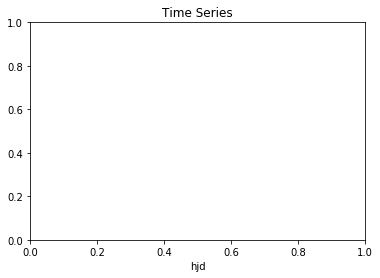

In [12]:
from rama.tools.time import plot
fig, ax = plt.subplots(1, 1)
plot(ax, cube_point)
fig.tight_layout()

In [13]:
from rama.tools.time import PlottableAxis
PlottableAxis(cube_point._index['magnitude']).error

<Quantity [ 0.00211324, 0.00265446, 0.00242693, 0.00250951, 0.00259727,
            0.00352634, 0.00255264, 0.00243124, 0.00250253, 0.00279542,
            0.00267379, 0.00330466, 0.00272647, 0.00267969, 0.00333398,
            0.00385069, 0.00323696, 0.00296548, 0.00301621, 0.00357741,
            0.00332674, 0.00351369, 0.00366553, 0.00409392, 0.00432619,
            0.00416532, 0.004831  , 0.00461638, 0.0045754 , 0.00470686,
            0.00361313, 0.00377722, 0.00382465, 0.00366826, 0.00382432,
            0.0040114 , 0.00390703, 0.00342238, 0.00358572, 0.00402034,
            0.00391165, 0.00407595, 0.00359357, 0.0035015 , 0.00377922,
            0.00708798, 0.00970818, 0.0037468 , 0.00421059, 0.0043198 ,
            0.00396233, 0.00513592, 0.00385994, 0.00378902, 0.0039174 ,
            0.00401238, 0.0041342 , 0.00362997, 0.00379297, 0.00388522,
            0.00407584, 0.00390029, 0.00350445, 0.00378448, 0.00350231,
            0.00477902, 0.00454823, 0.00470583, 0.00466657, 0.00

In [14]:
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
quantity_support()
plt.errorbar(time_series.time.measurement.value, time_series['flux'].measurement.value, yerr=time_series['flux'].stat_error.radius.value, fmt='.')

AttributeError: 'numpy.ndarray' object has no attribute 'value'

So now we can take advantage of Astropy's capabilities to transform the position from one frame to another, or to get the corresponding galactic coordinates.

In [15]:
time_series_xml = "time-series.vot.xml"

ts_parser = VodmlParser(time_series_xml)

dataset = ts_parser.find_instances(ObsDataset)[0]

points = ts_parser.find_instances(NdPoint)
ts = points[0]

NameError: name 'VodmlParser' is not defined

And finally here are the plots. We instantiate the plotting client and then we use it to plot the time series along different axes in 2D plots.

In [ ]:
points_plot = NdPointPlot(ts, dataset)
points_plot.plot_xy_by_name('hjd', 'flux')
points_plot.plot_xy_by_name('hjd', 'magnitude', fmt='g.')
points_plot.plot_xy_by_name('flux', 'magnitude', fmt='r.')

<a id="invariance"></a>
Invariance of VODML serializations
=====================

We introduced an example with a simple sky position in our first example. Then we parsed a much more complicated serialization of a time series, which also includes positional information.

It is worth stressing that despite the fact that the sky position is deep inside an instance of a different data model, the simplistic client we built above still works, i.e.:

In [ ]:
new_pos = ts_parser.find_instances(SkyPosition)[0]
new_astro_pos = VoSkyCoord(new_pos)
print(new_astro_pos)

<a id="tests"></a>
Tests
===

In [ ]:
assert 10.684591543245 == astropos_fk5_j2000.fk5.ra.deg
assert 41.269171456186264 == astropos_fk5_j2000.fk5.dec.deg

assert 10.68458000395546 == astropos_icrs.ra.deg
assert 41.269169997096114 == astropos_icrs.dec.deg

assert_approx_equal(121.17424181434197, astropos_galactic.l.deg, significant=10)
assert_approx_equal(-21.57288557543883, astropos_galactic.b.deg, significant=10)

In [ ]:
assert 1 == len(sky_positions)
assert 10.34209135 == pos.coord.ra.value
assert 41.13232112 == pos.coord.dec.value
assert "FK5" == pos.coord_frame.space_ref_frame.value
assert "J1975" == pos.coord_frame.equinox.value
assert "TOPOCENTER" == pos.coord_frame.ref_position.position.value

In [ ]:
assert 1 == len(points)
assert "TIMESERIES" == dataset.data_product_type.value
assert "K2C9 VST MOA-2016-BLG-0254_VST_r_SDSS78.t" == dataset.data_id[0].title.value
assert "ivo://org.gavo.dc/~?k2c9vst/data/?MOA-2016-BLG-0254_VST_r_SDS..." == dataset.curation[0].publisher_did.value
assert "http://archive.eso.org/wdb/wdb/eso/sched_rep_arc/query?progid..." == dataset.curation[0].reference[0].ref_code.value

In [ ]:
time = ts.axis[0].instance[0]
position = ts.axis[1].instance[0]
flux = ts.axis[2].instance[0]
magnitude = ts.axis[3].instance[0]

assert isinstance(time, StdTimeMeasure)
assert isinstance(position, SkyPosition)
assert isinstance(flux, GenericCoordMeasure)
assert isinstance(magnitude, GenericCoordMeasure)

assert 75 == len(time.coord.date)
assert 2457557.6532016 == time.coord.date.value[0]
assert "TT" == time.coord_frame.timescale.value
assert "HELIOCENTER" == time.coord_frame.ref_position.position.value
assert 269.82846 == position.coord.ra.value
assert -27.99478 == position.coord.dec.value
assert 'deg' == position.coord.ra.unit
assert 'deg' == position.coord.dec.unit
assert -14776.0666 == flux.coord.cval[1].value
assert 261.0369873046875 == flux.error[0].stat_error.radius[-1].value
assert 16.40898 == magnitude.coord.cval[2].value
assert 0.002509509911760688 == magnitude.error[0].stat_error.radius[3].value

assert 'mag' == magnitude.coord.cval.unit
assert 'adu' == flux.coord.cval.unit

<a id="beta_lyr"></a>
Beta Lyr time series from Vizier
======================

In [ ]:
betalyr_xml = "betalyr-vizier.vot.xml"
betalyr_parser = VodmlParser(betalyr_xml)

betalyr_dataset = betalyr_parser.find_instances(ObsDataset)[0]
betalyr_points = betalyr_parser.find_instances(NdPoint)
betalyr = betalyr_points[0]

In [ ]:
betalyr_plot = NdPointPlot(betalyr, betalyr_dataset)

In [ ]:
betalyr_plot.dependent

In [ ]:
betalyr_plot.independent

In [ ]:
betalyr_plot.plot_xy_by_name('j_time', 'j_mag')
betalyr_plot.plot_xy_by_name('h_time', 'h_mag')
betalyr_plot.plot_xy_by_name('k_time', 'k_mag')
betalyr_plot.plot_xy_by_name('l_time', 'l_mag')
betalyr_plot.plot_xy_by_name('m_time', 'm_mag')

# 

In [25]:
import numpy as np
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()
x = np.array([1, 2, 3]) * u.Unit('')
y = np.array([1, 2, 3]) * u.Unit('Jy')
err = np.array([0.1, 0.1, 0.1]) * u.Unit('Jy')

<Container object of 3 artists>

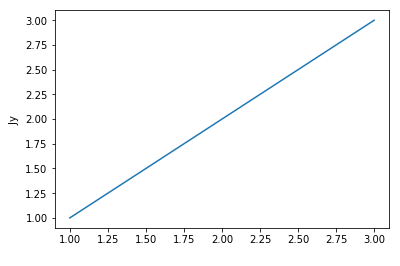

In [27]:
from matplotlib import pyplot as plt
plt.errorbar(x, y)